In [1]:
import h5py
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input,Dense,Conv2D,MaxPooling2D,UpSampling2D,Flatten,add
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
save = False # should models be saved? Warning: Will overwrite previously trained models

In [3]:
tf.keras.backend.clear_session()

In [4]:
f = h5py.File('phase_diagram_rephased.h5', 'r')

In [5]:
phase = f["parameter"]["phase"][:]
freq = f["parameter"]["freq"][:]

In [6]:
uphase = np.unique(phase)
ufreq = np.unique(freq)
X,Y = np.meshgrid(uphase,ufreq)

In [7]:
def train_mask(freq0,freq1,phase0,phase1):
    pick_freq = np.where((freq >= freq0) & (freq <= freq1))
    pick_phase = np.where((phase >= phase0) & (phase <= phase1))
    return np.intersect1d(pick_freq,pick_phase)

In [8]:
print(freq.min(),freq.max(),phase.min(),phase.max())

5.1000000000000005 7.8 -180.0 180.0


In [9]:
images = f["images"][:][:,:,:,np.newaxis]
images.shape

(10436, 56, 56, 1)

In [10]:
# Theory data
file = h5py.File("phase_diagram_theory.h5","r")
file.keys()

chern_number = file["chern_number"][:]
freq0 = file["freq"][:]
phase0 = file["phase"][:]

x0,y0 = np.meshgrid(phase0,freq0)

In [11]:
outss = []
for j in range(3):
    outss.append(np.load(f"data/boundary_convergence_outs{j+1}.npz",allow_pickle=True)["outs"])

In [12]:
train_freqsss = []
starts = np.linspace(5.3,6,5)
print(starts)
train_freqss = [[(5,start)] for start in starts]
train_freqsss.append(train_freqss)

starts = [0.1,0.2,0.3,0.4]
print(starts)
train_freqss = [[(6.6-start,6.5+start)] for start in starts]
train_freqsss.append(train_freqss)

starts = np.arange(7.2,7.6,0.1)
print(starts)
train_freqss = [[(start,7.8)] for start in starts]
train_freqsss.append(train_freqss)

[5.3   5.475 5.65  5.825 6.   ]
[0.1, 0.2, 0.3, 0.4]
[7.2 7.3 7.4 7.5]


In [13]:
color = ["tab:blue","tab:orange", "tab:green", "tab:red", "tab:purple"]

In [17]:
train_phases = [(-180,180)]

In [18]:
train_freqsss[0]

[[(5, 5.3)], [(5, 5.475)], [(5, 5.65)], [(5, 5.825)], [(5, 6.0)]]

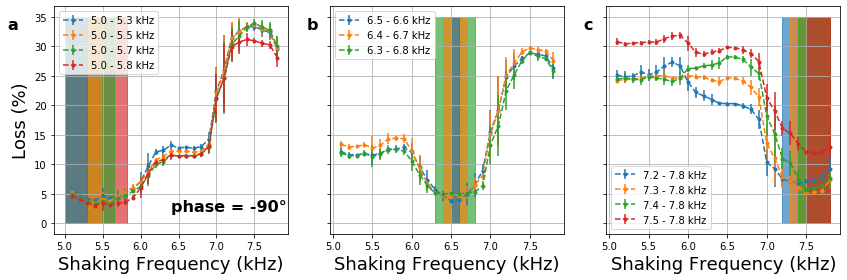

In [26]:
fig, axs = plt.subplots(ncols=3,figsize=(12,4),sharey=True)

j = 0
outs = outss[j]
train_freqss = train_freqsss[j]
ax = axs[j]
ax.grid()
for i in range(len(train_freqss)-1):
    out, dout = 100*outs[i]
    pick_phase = 18
    ax.errorbar(Y[:,pick_phase],out.T[:,pick_phase],yerr=dout.T[:,pick_phase], fmt = ".--",label="{:.1f} - {:.1f} kHz".format(*train_freqss[i][0]))
ax.legend()
ax.set_ylabel("Loss (%)", fontsize=18)
ax.set_xlabel("Shaking Frequency (kHz)", fontsize=18)
for i in np.arange(3,-1,-1):
    train_freqs = train_freqss[i]
    for phases,freqs in zip(train_phases,train_freqs):
        ax.fill_between(*[freqs],0,35,alpha=0.65,color=color[i])

j = 1
outs = outss[j]
train_freqss = train_freqsss[j]
ax = axs[j]
ax.grid()
for i in range(len(train_freqss)-1):
    out, dout = 100*outs[i]
    pick_phase = 18
    ax.errorbar(Y[:,pick_phase],out.T[:,pick_phase],yerr=dout.T[:,pick_phase], fmt = ".--",label="{:.1f} - {:.1f} kHz".format(*train_freqss[i][0]))
ax.legend()
ax.set_xlabel("Shaking Frequency (kHz)", fontsize=18)
for i in np.arange(2,-1,-1):
    train_freqs = train_freqss[i]
    for phases,freqs in zip(train_phases,train_freqs):
        ax.fill_between(*[freqs],0,35,alpha=0.65,color=color[i])

j = 2
outs = outss[j]
train_freqss = train_freqsss[j]
ax = axs[j]
ax.grid()
for i in range(len(train_freqss)):
    out, dout = 100*outs[i]
    pick_phase = 18
    ax.errorbar(Y[:,pick_phase],out.T[:,pick_phase],yerr=dout.T[:,pick_phase], fmt = ".--",label="{:.1f} - {:.1f} kHz".format(*train_freqss[i][0]))
ax.legend()
ax.set_xlabel("Shaking Frequency (kHz)", fontsize=18)
for i in np.arange(4):
    train_freqs = train_freqss[i]
    for phases,freqs in zip(train_phases,train_freqs):
        ax.fill_between(*[freqs],0,35,alpha=0.65,color=color[i])
axs[0].text(0.5,0.1,"phase = -90°",weight="bold", transform = axs[0].transAxes,fontsize=16)
plt.tight_layout()

axs[0].text(-0.2,0.9,"a",weight="bold", transform = axs[0].transAxes,fontsize=16)
axs[1].text(-0.1,0.9,"b",weight="bold", transform = axs[1].transAxes,fontsize=16)
axs[2].text(-0.1,0.9,"c",weight="bold", transform = axs[2].transAxes,fontsize=16)

plt.savefig("boundary_convergence.pdf")

# Training part

In [11]:
rate=0.2 # Dropout percentage
bottleneck = 50 # latent space dimension, does not make great differences

In [13]:
def ConvFully2(loss,optimizer,activation0,activation,x_shape,dim1=(16,(3,3)),dim2=(16,(3,3))):
    """ 
    Pretty Standard Convolutional Autoencoder with a fully-connected latent space
    activation0: Activations "inside" the CAE
    activation: Last activation (important depending on the range of the pixel values)
    """
    in_dim = x_shape
    input_img = Input(shape=in_dim)
   
    x1 = Conv2D(*dim1, activation=activation0, padding='same')(input_img)
    x2 = MaxPooling2D((2, 2), padding='same')(x1)
    x2 = Conv2D(*dim2, activation=activation0, padding='same')(x2)
    x3 = MaxPooling2D((2, 2), padding='same')(x2)
    encoded = Conv2D(*dim2, activation=activation0, padding='same')(x3)
    
    encoded = Flatten()(encoded)
    encoded = Dense(units=50,activation=activation0)(encoded)
    encoded = tf.keras.layers.Dropout(rate)(encoded)
    encoded = Dense(dim2[0]*14*14,activation=activation0)(encoded)
    encoded = tf.keras.layers.Dropout(rate)(encoded)
    encoded = tf.keras.layers.Reshape((14,14,dim2[0]))(encoded)

    y=UpSampling2D((2, 2))(encoded)
    y=Conv2D(*dim1, activation=activation0, padding='same')(y)
    y=UpSampling2D((2, 2))(y)
    decoded = Conv2D(x_shape[-1], dim1[1], activation=activation, padding='same')(y)

    cnn = Model(input_img, decoded)
    cnn.compile(loss=loss,optimizer=optimizer)
    return cnn

In [14]:
# Show Network architecture
cnn = ConvFully2("mse","adam","linear","relu",x_shape=(56,56,1))
cnn.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 56, 56, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 56, 56, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 16)        2320      
_________________________________________________________________
flatten (Flatten)            (None, 3136)             

In [ ]:
def norm2(y_true,y_pred):
    """ just the standard l2 norm, needed for evaluation """
    return np.sqrt(np.sum(np.abs(y_true - y_pred)**2))

def eval_loss(x_batch,y_batch,norm=norm2):
    a = []
    for i in range(x_batch.shape[0]):
        a.append(norm(x_batch[i],y_batch[i]))
    return np.array(a)

def training_run(x_train,choose_cnn=ConvFully2, name = "Appendix-B", provide_cnn = False,
             load_prev=False, num_epochs = 50,  verbose_val=1, batch_size = 16, shuffle=True, early=False,
             loss="mse", activation0 = 'relu', activation = 'linear', optimizer = "adam",
             dim1=(16,(3,3)),dim2=(16,(3,3)),ssc1=False,ssc2=False, training = 0):
    """
    provide_cnn is to continue the training of a cnn
    load_prev is to load a previously trained network under the same paramters
    x_train provide training data
    """
        
    name_string = "{}".format(training)
    CNN_filepath= 'CNN_data/Anomaly-Detection_' + name_string + 'weights.hdf5'

    cnn = choose_cnn(loss,optimizer,activation0,activation,x_train.shape[1:],dim1,dim2) #ssc1, ssc2
    if load_prev:
        cnn.load_weights(CNN_filepath)
    else:
        if provide_cnn:
            cnn = provide_cnn
        # checkpoint
        checkpoint = ModelCheckpoint(CNN_filepath, monitor='val_loss', verbose=0, save_best_only=False, mode='max')
        callbacks_list = [checkpoint]
        if early:
            early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto', baseline=None)#, restore_best_weights=True)
            callbacks_list.append(early_stop)

        history=cnn.fit(x_train, x_train, epochs=num_epochs, batch_size=batch_size,validation_data=(x_train,x_train),callbacks=callbacks_list,verbose=verbose_val,shuffle=shuffle)
        np.savez('CNN_data/Anomaly-Detection_history_cnn_' + name_string + '.npz',loss=history.history['loss'],val_loss=history.history['val_loss'])#,acc=history.history['acc'],val_acc=history.history['val_acc'])

    # training history
    plotname = 'plots/Anomaly-Detection_training-history' +  name_string
    hist = np.load('CNN_data/Anomaly-Detection_history_cnn_' + name_string + '.npz',allow_pickle="True")
    loss = hist["loss"]
    val_loss = hist["val_loss"]
    plt.plot(loss, linewidth=2, label='Train')
    plt.plot(val_loss, linewidth=2, label='Val')
    plt.legend(loc='upper right')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.yscale("log")
    #plt.ylim(ymin=0.70,ymax=1)
    plt.savefig(plotname + 'training.png', format="png")
    plt.show()
    return cnn

In [33]:
# A full run consisting of training and evaluation
def full_run(x_train,
             dim1=(16,(3,3)),dim2 = (16,(3,3)), activation = "linear", activation0="relu",
             choose_cnn = ConvFully2, provide_cnn = False, verbose_val = 0,
             num_batch_epochs = 3, batch_epochs=15, batch_size = 16, load_prev = False, name = "master",
             pick_phase = 18):
    """
    choose_cnn: provide function that builds respective architecture
    provide_cnn: continue training of a previous NN instance
    batch_epochs: number of epochs per training-batch
    num_batch_epochs: number of training-batches (sorry for confusing terminology of "batch")
    batch_size: tf parameter
    name: provide name for saving network parameters
    load_prev: when the training was already done, reload parameters (all hyper-parameters and parameters must match!)
    pick_phase: for evaluation, which phase is picked to display the single cut
    """
    
    for batch in range(num_batch_epochs):
        if batch == 0:
            provide_cnn = provide_cnn
        else:
            provide_cnn = cnn1
        cnn1 = training(x_train = x_train,choose_cnn = choose_cnn, name = name, provide_cnn = provide_cnn,
             load_prev=load_prev, num_epochs = batch_epochs,  verbose_val=verbose_val, batch_size = batch_size, shuffle=True, early=False,
             loss="mse", activation0 = 'relu', activation = 'linear', optimizer = "adam",
               dim1=dim1,dim2=dim2)
        out,dout = create_out(cnn1)
        
        
        phase90 = X[:,pick_phase][0]
        ### Plot
        if False:
            fig, ax = plt.subplots()
            # plot result
            im = ax.pcolormesh(X,Y,out.T,cmap="jet")
            fig.colorbar(im,ax=ax)
            # theory curve
            ax.contour(x0,y0,np.round(chern_number.T),levels=2)
            ax.set_xlim(uphase.min(),uphase.max())
            ax.set_ylim(ufreq.min(),ufreq.max())
            ax.plot([phase90]*2,[ufreq.min(),ufreq.max()],"--")
            for phases,freqs in zip(train_phases,train_freqs):
                plt.fill_between(*[phases],*freqs,alpha=0.3)
            plt.show()
        pick_freq  = 14
        fig, ax = plt.subplots()
        plt.errorbar(Y[:,pick_freq],out.T[:,pick_freq],yerr=dout.T[:,pick_freq])
        plt.title(f"phase = {Y[pick_freq,:][0]}")
        plt.show()
    return cnn1

In [27]:
def create_out(cnn1):
    """
    Creates (dim_freq, dim_phase) matrix of the output loss and the standard deviation
    """
    images_out = cnn1.predict(images)

    res = eval_loss(images,images_out,norm=norm2)/eval_loss(images,0*images,norm=norm2)

    uphase = np.unique(phase)

    ufreq = np.unique(freq)

    X,Y = np.meshgrid(uphase,ufreq)

    out = np.zeros((len(uphase),len(ufreq)))
    dout = np.zeros((len(uphase),len(ufreq)))

    for i,ph in enumerate(uphase):
        for j,fr in enumerate(ufreq):
            mask = np.intersect1d(np.where(freq == fr),np.where(phase == ph))
            out[i,j] = np.mean(res[mask])
            dout[i,j] = np.std(res[mask])
    return out, dout

# Low Freqs

In [28]:
tf.keras.backend.clear_session()

In [96]:
starts = [0.1,0.2,0.3,0.4]
print(starts)
train_freqss = [[(6.6-start,6.5+start)] for start in starts]

[0.1, 0.2, 0.3, 0.4]


In [29]:
starts = np.linspace(5.3,6,5)
print(starts)
train_freqss = [[(5,start)] for start in starts]

[5.3   5.475 5.65  5.825 6.   ]


In [30]:
cnns = [None] * len(train_freqss)

run 0
[(1116, 56, 56, 1)]
(1116, 56, 56, 1)
Epoch 1/30
70/70 [==============================] - 1s 14ms/step - loss: 0.0400 - val_loss: 0.0079
Epoch 2/30
70/70 [==============================] - 1s 12ms/step - loss: 0.0092 - val_loss: 0.0035
Epoch 3/30
70/70 [==============================] - 1s 11ms/step - loss: 0.0057 - val_loss: 0.0024
Epoch 4/30
70/70 [==============================] - 1s 11ms/step - loss: 0.0037 - val_loss: 0.0020
Epoch 5/30
70/70 [==============================] - 1s 12ms/step - loss: 0.0029 - val_loss: 0.0017
Epoch 6/30
70/70 [==============================] - 1s 11ms/step - loss: 0.0025 - val_loss: 0.0013
Epoch 7/30
70/70 [==============================] - 1s 11ms/step - loss: 0.0021 - val_loss: 9.6193e-04
Epoch 8/30
70/70 [==============================] - 1s 11ms/step - loss: 0.0018 - val_loss: 8.2981e-04
Epoch 9/30
70/70 [==============================] - 1s 11ms/step - loss: 0.0017 - val_loss: 7.7015e-04
Epoch 10/30
70/70 [==============================] - 

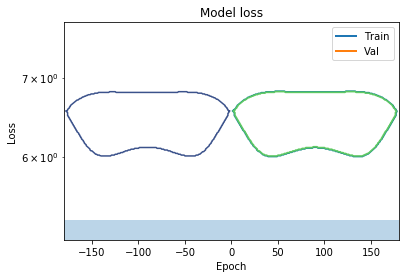

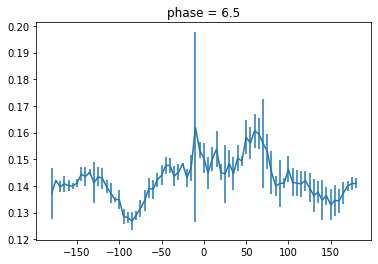

run 1
[(1488, 56, 56, 1)]
(1488, 56, 56, 1)
Epoch 1/30
93/93 [==============================] - 1s 12ms/step - loss: 0.0332 - val_loss: 0.0093
Epoch 2/30
93/93 [==============================] - 1s 10ms/step - loss: 0.0073 - val_loss: 0.0021
Epoch 3/30
93/93 [==============================] - 1s 10ms/step - loss: 0.0034 - val_loss: 0.0019
Epoch 4/30
93/93 [==============================] - 1s 10ms/step - loss: 0.0026 - val_loss: 0.0015
Epoch 5/30
93/93 [==============================] - 1s 10ms/step - loss: 0.0020 - val_loss: 8.5485e-04
Epoch 6/30
93/93 [==============================] - 1s 10ms/step - loss: 0.0017 - val_loss: 7.2580e-04
Epoch 7/30
93/93 [==============================] - 1s 10ms/step - loss: 0.0016 - val_loss: 6.7640e-04
Epoch 8/30
93/93 [==============================] - 1s 10ms/step - loss: 0.0015 - val_loss: 8.4461e-04
Epoch 9/30
93/93 [==============================] - 1s 10ms/step - loss: 0.0014 - val_loss: 6.4309e-04
Epoch 10/30
93/93 [==========================

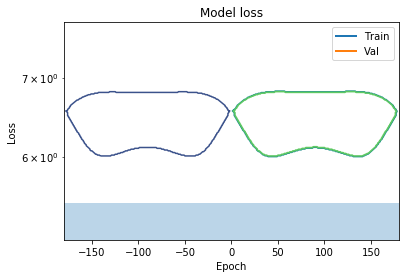

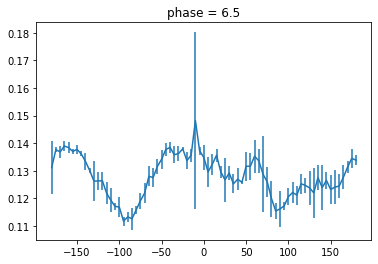

run 2
[(2232, 56, 56, 1)]
(2232, 56, 56, 1)
Epoch 1/30
140/140 [==============================] - 2s 13ms/step - loss: 0.0372 - val_loss: 0.0087
Epoch 2/30
140/140 [==============================] - 2s 11ms/step - loss: 0.0056 - val_loss: 0.0021
Epoch 3/30
140/140 [==============================] - 2s 11ms/step - loss: 0.0033 - val_loss: 0.0020
Epoch 4/30
140/140 [==============================] - 2s 11ms/step - loss: 0.0029 - val_loss: 0.0016
Epoch 5/30
140/140 [==============================] - 2s 11ms/step - loss: 0.0025 - val_loss: 0.0013
Epoch 6/30
140/140 [==============================] - 1s 11ms/step - loss: 0.0022 - val_loss: 0.0011
Epoch 7/30
140/140 [==============================] - 2s 11ms/step - loss: 0.0022 - val_loss: 9.4814e-04
Epoch 8/30
140/140 [==============================] - 2s 11ms/step - loss: 0.0020 - val_loss: 9.9922e-04
Epoch 9/30
140/140 [==============================] - 2s 11ms/step - loss: 0.0020 - val_loss: 9.1200e-04
Epoch 10/30
140/140 [==============

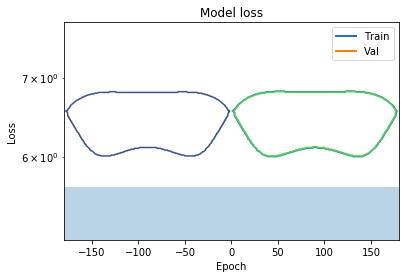

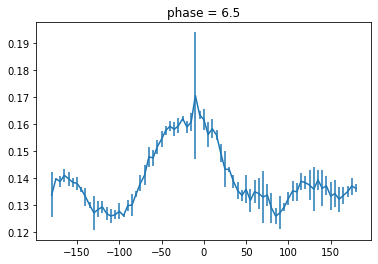

run 3
[(2976, 56, 56, 1)]
(2976, 56, 56, 1)
Epoch 1/30
186/186 [==============================] - 2s 11ms/step - loss: 0.0176 - val_loss: 0.0030
Epoch 2/30
186/186 [==============================] - 2s 10ms/step - loss: 0.0034 - val_loss: 0.0015
Epoch 3/30
186/186 [==============================] - 2s 10ms/step - loss: 0.0020 - val_loss: 7.8478e-04
Epoch 4/30
186/186 [==============================] - 2s 10ms/step - loss: 0.0015 - val_loss: 7.3869e-04
Epoch 5/30
186/186 [==============================] - 2s 10ms/step - loss: 0.0014 - val_loss: 6.5255e-04
Epoch 6/30
186/186 [==============================] - 2s 10ms/step - loss: 0.0013 - val_loss: 6.9976e-04
Epoch 7/30
186/186 [==============================] - 2s 9ms/step - loss: 0.0012 - val_loss: 6.2634e-04
Epoch 8/30
186/186 [==============================] - 2s 10ms/step - loss: 0.0012 - val_loss: 6.0961e-04
Epoch 9/30
186/186 [==============================] - 2s 10ms/step - loss: 0.0011 - val_loss: 7.2266e-04
Epoch 10/30
186/186 

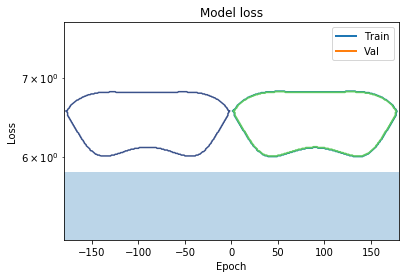

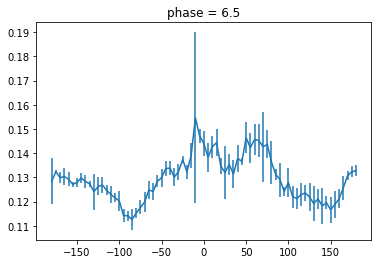

run 4
[(3721, 56, 56, 1)]
(3721, 56, 56, 1)
Epoch 1/30
233/233 [==============================] - 3s 13ms/step - loss: 0.0165 - val_loss: 0.0023
Epoch 2/30
233/233 [==============================] - 2s 11ms/step - loss: 0.0033 - val_loss: 0.0015
Epoch 3/30
233/233 [==============================] - 2s 11ms/step - loss: 0.0021 - val_loss: 9.4540e-04
Epoch 4/30
233/233 [==============================] - 2s 10ms/step - loss: 0.0017 - val_loss: 7.8353e-04
Epoch 5/30
233/233 [==============================] - 2s 11ms/step - loss: 0.0016 - val_loss: 7.4959e-04
Epoch 6/30
233/233 [==============================] - 2s 11ms/step - loss: 0.0014 - val_loss: 7.1635e-04
Epoch 7/30
233/233 [==============================] - 2s 11ms/step - loss: 0.0013 - val_loss: 6.6053e-04
Epoch 8/30
233/233 [==============================] - 2s 10ms/step - loss: 0.0011 - val_loss: 6.0251e-04
Epoch 9/30
233/233 [==============================] - 2s 10ms/step - loss: 0.0010 - val_loss: 5.7344e-04
Epoch 10/30
233/233

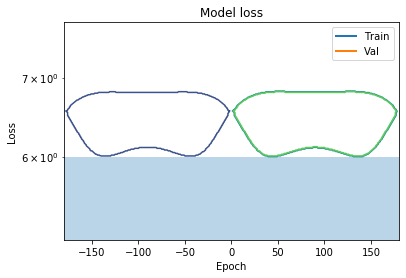

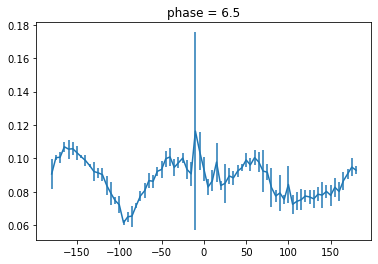

In [32]:
for i,train_freqs in enumerate(train_freqss):
    print(f"run {i}")
    train_phases = [(-180,180)]
    x_train = []
    for phases,freqs in zip(train_phases,train_freqs):
        x_train.append(f["images"][train_mask(*freqs,*phases)][:,:,:,np.newaxis])
    print([_.shape for _ in x_train])
    x_train = np.concatenate(x_train)
    print(x_train.shape)
    fig, ax = plt.subplots()
    ax.contour(x0,y0,np.round(chern_number.T),levels=2)
    for phases,freqs in zip(train_phases,train_freqs):
        plt.fill_between(*[phases],*freqs,alpha=0.3)
    plt.ylim(freq.min(),freq.max())
    plt.xlim(phase.min(),phase.max())

    cnns[i] = full_run(x_train, verbose_val=1,choose_cnn = ConvFully2,load_prev=False,num_batch_epochs = 1, batch_epochs=30, name ="Top_{}".format(train_phases[0][0]), pick_phase=18)

run 1
[(1488, 56, 56, 1)]
(1488, 56, 56, 1)
Epoch 1/30
93/93 [==============================] - 1s 12ms/step - loss: 0.0385 - val_loss: 0.0096
Epoch 2/30
93/93 [==============================] - 1s 10ms/step - loss: 0.0091 - val_loss: 0.0028
Epoch 3/30
93/93 [==============================] - 1s 10ms/step - loss: 0.0036 - val_loss: 0.0019
Epoch 4/30
93/93 [==============================] - 1s 10ms/step - loss: 0.0028 - val_loss: 0.0012
Epoch 5/30
93/93 [==============================] - 1s 10ms/step - loss: 0.0021 - val_loss: 9.1368e-04
Epoch 6/30
93/93 [==============================] - 1s 10ms/step - loss: 0.0018 - val_loss: 7.7297e-04
Epoch 7/30
93/93 [==============================] - 1s 10ms/step - loss: 0.0017 - val_loss: 7.2292e-04
Epoch 8/30
93/93 [==============================] - 1s 10ms/step - loss: 0.0015 - val_loss: 6.5266e-04
Epoch 9/30
93/93 [==============================] - 1s 10ms/step - loss: 0.0013 - val_loss: 6.1764e-04
Epoch 10/30
93/93 [==========================

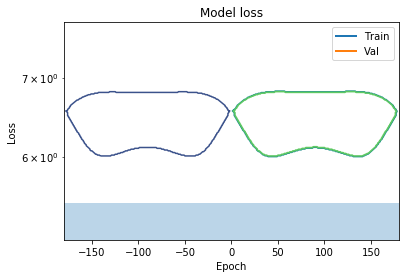

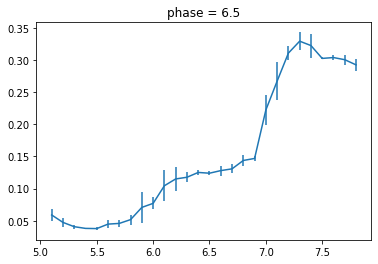

In [66]:
i = 1
train_freqs = train_freqss[i]
print(f"run {i}")
train_phases = [(-180,180)]
x_train = []
for phases,freqs in zip(train_phases,train_freqs):
    x_train.append(f["images"][train_mask(*freqs,*phases)][:,:,:,np.newaxis])
print([_.shape for _ in x_train])
x_train = np.concatenate(x_train)
print(x_train.shape)
fig, ax = plt.subplots()
ax.contour(x0,y0,np.round(chern_number.T),levels=2)
for phases,freqs in zip(train_phases,train_freqs):
    plt.fill_between(*[phases],*freqs,alpha=0.3)
plt.ylim(freq.min(),freq.max())
plt.xlim(phase.min(),phase.max())

cnns[i] = full_run(x_train, verbose_val=1,choose_cnn = ConvFully2,load_prev=False,num_batch_epochs = 1, batch_epochs=30, name ="Top_{}".format(train_phases[0][0]), pick_phase=18)

In [67]:
outs = [create_out(cnn) for cnn in cnns]

In [69]:
np.savez("data/boundary_convergence_outs1",outs=outs)

In [70]:
outs = np.load("data/boundary_convergence_outs1.npz",allow_pickle=True)["outs"]

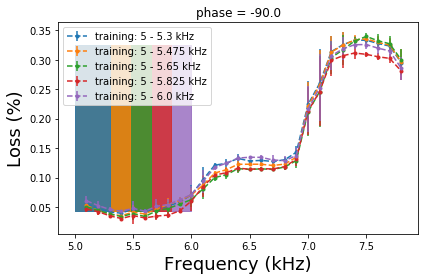

In [71]:
fig, ax = plt.subplots()
color = ["tab:blue","tab:orange", "tab:green", "tab:red", "tab:purple"]
for i in range(len(train_freqss)):
    out, dout = outs[i]
    pick_phase = 18
    plt.errorbar(Y[:,pick_phase],out.T[:,pick_phase],yerr=dout.T[:,pick_phase], fmt = ".--",label=f"training: 5 - {starts[i]} kHz")
plt.legend()
plt.ylabel("Loss (%)", fontsize=18)
plt.xlabel("Frequency (kHz)", fontsize=18)
plt.title(f"phase = {X[:,pick_phase][0]}")
for i in np.arange(4,-1,-1):
    train_freqs = train_freqss[i]
    for phases,freqs in zip(train_phases,train_freqs):
        plt.fill_between(*[freqs],out.T[:,pick_phase].min(),out.T[:,pick_phase].max(),alpha=0.8,color=color[i])
plt.tight_layout()
plt.show()

# Topological

In [72]:
tf.keras.backend.clear_session()

In [96]:
starts = [0.1,0.2,0.3,0.4]
print(starts)
train_freqss = [[(6.6-start,6.5+start)] for start in starts]

[0.1, 0.2, 0.3, 0.4]


In [97]:
cnns = [None] * len(train_freqss)

run 0
[(746, 56, 56, 1)]
(746, 56, 56, 1)
Epoch 1/30
47/47 [==============================] - 1s 16ms/step - loss: 0.0661 - val_loss: 0.0161
Epoch 2/30
47/47 [==============================] - 1s 12ms/step - loss: 0.0168 - val_loss: 0.0119
Epoch 3/30
47/47 [==============================] - 1s 12ms/step - loss: 0.0145 - val_loss: 0.0102
Epoch 4/30
47/47 [==============================] - 1s 12ms/step - loss: 0.0094 - val_loss: 0.0039
Epoch 5/30
47/47 [==============================] - 1s 13ms/step - loss: 0.0056 - val_loss: 0.0033
Epoch 6/30
47/47 [==============================] - 1s 12ms/step - loss: 0.0048 - val_loss: 0.0030
Epoch 7/30
47/47 [==============================] - 1s 12ms/step - loss: 0.0041 - val_loss: 0.0027
Epoch 8/30
47/47 [==============================] - 1s 12ms/step - loss: 0.0036 - val_loss: 0.0020
Epoch 9/30
47/47 [==============================] - 1s 12ms/step - loss: 0.0029 - val_loss: 0.0015
Epoch 10/30
47/47 [==============================] - 1s 12ms/step -

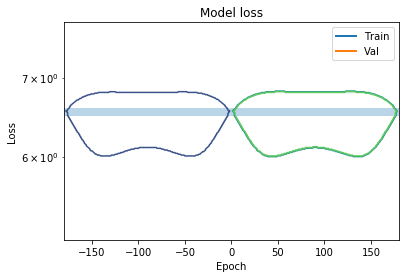

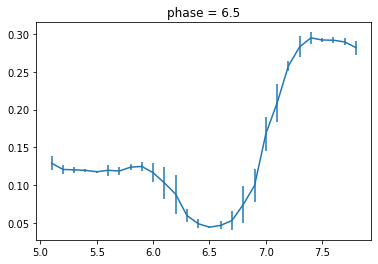

run 1
[(1492, 56, 56, 1)]
(1492, 56, 56, 1)
Epoch 1/30
94/94 [==============================] - 1s 15ms/step - loss: 0.0482 - val_loss: 0.0121
Epoch 2/30
94/94 [==============================] - 1s 11ms/step - loss: 0.0088 - val_loss: 0.0036
Epoch 3/30
94/94 [==============================] - 1s 11ms/step - loss: 0.0051 - val_loss: 0.0031
Epoch 4/30
94/94 [==============================] - 1s 11ms/step - loss: 0.0042 - val_loss: 0.0025
Epoch 5/30
94/94 [==============================] - 1s 11ms/step - loss: 0.0036 - val_loss: 0.0019
Epoch 6/30
94/94 [==============================] - 1s 11ms/step - loss: 0.0031 - val_loss: 0.0017
Epoch 7/30
94/94 [==============================] - 1s 11ms/step - loss: 0.0030 - val_loss: 0.0017
Epoch 8/30
94/94 [==============================] - 1s 11ms/step - loss: 0.0029 - val_loss: 0.0016
Epoch 9/30
94/94 [==============================] - 1s 11ms/step - loss: 0.0028 - val_loss: 0.0017
Epoch 10/30
94/94 [==============================] - 1s 11ms/step

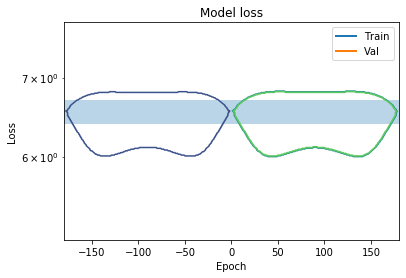

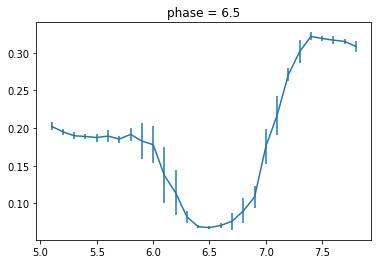

run 2
[(2238, 56, 56, 1)]
(2238, 56, 56, 1)
Epoch 1/30
140/140 [==============================] - 2s 13ms/step - loss: 0.0238 - val_loss: 0.0034
Epoch 2/30
140/140 [==============================] - 1s 10ms/step - loss: 0.0046 - val_loss: 0.0022
Epoch 3/30
140/140 [==============================] - 1s 11ms/step - loss: 0.0030 - val_loss: 0.0015
Epoch 4/30
140/140 [==============================] - 2s 11ms/step - loss: 0.0024 - val_loss: 0.0012
Epoch 5/30
140/140 [==============================] - 1s 10ms/step - loss: 0.0021 - val_loss: 0.0010
Epoch 6/30
140/140 [==============================] - 1s 10ms/step - loss: 0.0019 - val_loss: 0.0010
Epoch 7/30
140/140 [==============================] - 1s 10ms/step - loss: 0.0017 - val_loss: 8.3681e-04
Epoch 8/30
140/140 [==============================] - 1s 10ms/step - loss: 0.0017 - val_loss: 8.8849e-04
Epoch 9/30
140/140 [==============================] - 2s 11ms/step - loss: 0.0016 - val_loss: 8.0208e-04
Epoch 10/30
140/140 [==============

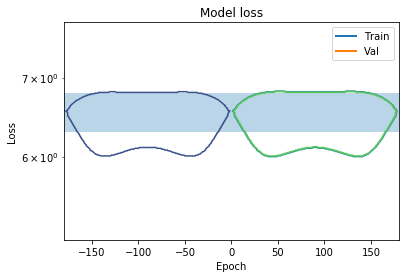

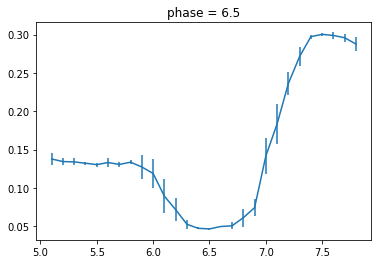

run 3
[(2984, 56, 56, 1)]
(2984, 56, 56, 1)
Epoch 1/30
187/187 [==============================] - 2s 12ms/step - loss: 0.0173 - val_loss: 0.0038
Epoch 2/30
187/187 [==============================] - 2s 11ms/step - loss: 0.0042 - val_loss: 0.0021
Epoch 3/30
187/187 [==============================] - 2s 11ms/step - loss: 0.0028 - val_loss: 0.0014
Epoch 4/30
187/187 [==============================] - 2s 11ms/step - loss: 0.0022 - val_loss: 0.0012
Epoch 5/30
187/187 [==============================] - 2s 11ms/step - loss: 0.0020 - val_loss: 0.0010
Epoch 6/30
187/187 [==============================] - 2s 11ms/step - loss: 0.0018 - val_loss: 8.8882e-04
Epoch 7/30
187/187 [==============================] - 2s 11ms/step - loss: 0.0017 - val_loss: 9.2302e-04
Epoch 8/30
187/187 [==============================] - 2s 11ms/step - loss: 0.0016 - val_loss: 8.2248e-04
Epoch 9/30
187/187 [==============================] - 2s 11ms/step - loss: 0.0016 - val_loss: 7.9434e-04
Epoch 10/30
187/187 [==========

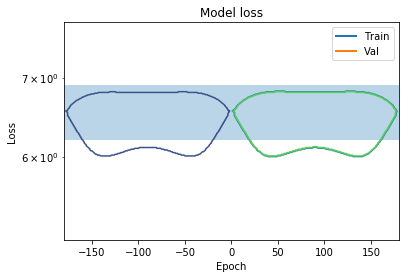

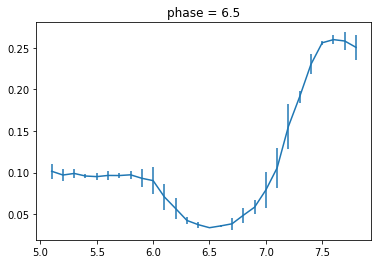

In [98]:
for i,train_freqs in enumerate(train_freqss):
    print(f"run {i}")
    train_phases = [(-180,180)]
    x_train = []
    for phases,freqs in zip(train_phases,train_freqs):
        x_train.append(f["images"][train_mask(*freqs,*phases)][:,:,:,np.newaxis])
    print([_.shape for _ in x_train])
    x_train = np.concatenate(x_train)
    print(x_train.shape)
    fig, ax = plt.subplots()
    ax.contour(x0,y0,np.round(chern_number.T),levels=2)
    for phases,freqs in zip(train_phases,train_freqs):
        plt.fill_between(*[phases],*freqs,alpha=0.3)
    plt.ylim(freq.min(),freq.max())
    plt.xlim(phase.min(),phase.max())

    cnns[i] = full_run(x_train, verbose_val=1,choose_cnn = ConvFully2,load_prev=False,num_batch_epochs = 1, batch_epochs=30, name ="Top_{}".format(train_phases[0][0]), pick_phase=18)

run 1
[(1492, 56, 56, 1)]
(1492, 56, 56, 1)


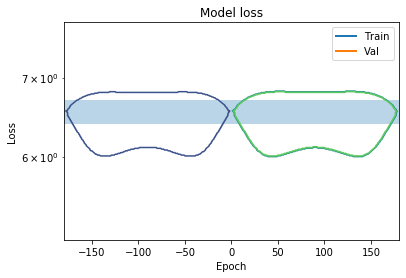

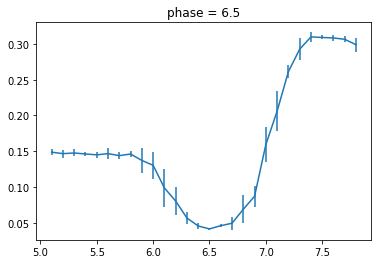

In [114]:
i = 1
train_freqs = train_freqss[i]
print(f"run {i}")
train_phases = [(-180,180)]
x_train = []
for phases,freqs in zip(train_phases,train_freqs):
    x_train.append(f["images"][train_mask(*freqs,*phases)][:,:,:,np.newaxis])
print([_.shape for _ in x_train])
x_train = np.concatenate(x_train)
print(x_train.shape)
fig, ax = plt.subplots()
ax.contour(x0,y0,np.round(chern_number.T),levels=2)
for phases,freqs in zip(train_phases,train_freqs):
    plt.fill_between(*[phases],*freqs,alpha=0.3)
plt.ylim(freq.min(),freq.max())
plt.xlim(phase.min(),phase.max())

cnns[i] = full_run(x_train, verbose_val=0,choose_cnn = ConvFully2,load_prev=False,num_batch_epochs = 1, batch_epochs=30, name ="Top_{}".format(train_phases[0][0]), pick_phase=18)

In [115]:
outs = [create_out(cnn) for cnn in cnns]

In [116]:
np.savez("data/boundary_convergence_outs2",outs=outs)

In [117]:
outs = np.load("data/boundary_convergence_outs2.npz",allow_pickle=True)["outs"]

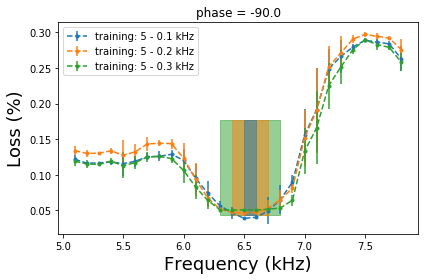

In [118]:
fig, ax = plt.subplots()
color = ["tab:blue","tab:orange", "tab:green", "tab:red", "tab:purple"]
for i in range(len(train_freqss)-1):
    out, dout = outs[i]
    pick_phase = 18
    plt.errorbar(Y[:,pick_phase],out.T[:,pick_phase],yerr=dout.T[:,pick_phase], fmt = ".--",label=f"training: 5 - {starts[i]} kHz")
plt.legend()
plt.ylabel("Loss (%)", fontsize=18)
plt.xlabel("Frequency (kHz)", fontsize=18)
plt.title(f"phase = {X[:,pick_phase][0]}")
for i in np.arange(2,-1,-1):
    train_freqs = train_freqss[i]
    for phases,freqs in zip(train_phases,train_freqs):
        plt.fill_between(*[freqs],outs[:,0,:,pick_phase].min(),outs[:,0,:,pick_phase].max(),alpha=0.5,color=color[i])
plt.tight_layout()
plt.show()

# High

In [119]:
tf.keras.backend.clear_session()

In [134]:
starts = np.arange(7.2,7.6,0.1)
print(starts)
train_freqss = [[(start,7.8)] for start in starts]

[7.2 7.3 7.4 7.5]


In [135]:
cnns = [None] * len(train_freqss)

run 0
[(2612, 56, 56, 1)]
(2612, 56, 56, 1)
Epoch 1/30
164/164 [==============================] - 2s 12ms/step - loss: 0.0268 - val_loss: 0.0049
Epoch 2/30
164/164 [==============================] - 2s 11ms/step - loss: 0.0059 - val_loss: 0.0026
Epoch 3/30
164/164 [==============================] - 2s 11ms/step - loss: 0.0040 - val_loss: 0.0022
Epoch 4/30
164/164 [==============================] - 2s 11ms/step - loss: 0.0033 - val_loss: 0.0016
Epoch 5/30
164/164 [==============================] - 2s 11ms/step - loss: 0.0030 - val_loss: 0.0018
Epoch 6/30
164/164 [==============================] - 2s 11ms/step - loss: 0.0027 - val_loss: 0.0016
Epoch 7/30
164/164 [==============================] - 2s 11ms/step - loss: 0.0026 - val_loss: 0.0018
Epoch 8/30
164/164 [==============================] - 2s 11ms/step - loss: 0.0025 - val_loss: 0.0016
Epoch 9/30
164/164 [==============================] - 2s 11ms/step - loss: 0.0025 - val_loss: 0.0016
Epoch 10/30
164/164 [==========================

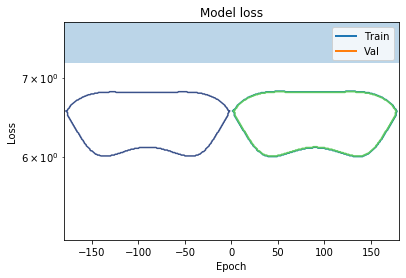

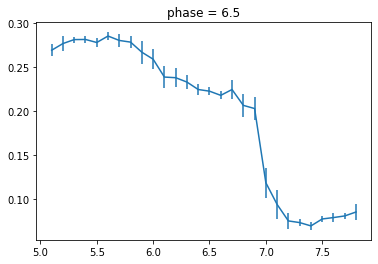

run 1
[(2239, 56, 56, 1)]
(2239, 56, 56, 1)
Epoch 1/30
140/140 [==============================] - 2s 12ms/step - loss: 0.0355 - val_loss: 0.0115
Epoch 2/30
140/140 [==============================] - 2s 11ms/step - loss: 0.0095 - val_loss: 0.0031
Epoch 3/30
140/140 [==============================] - 2s 11ms/step - loss: 0.0040 - val_loss: 0.0020
Epoch 4/30
140/140 [==============================] - 2s 11ms/step - loss: 0.0032 - val_loss: 0.0019
Epoch 5/30
140/140 [==============================] - 2s 11ms/step - loss: 0.0029 - val_loss: 0.0019
Epoch 6/30
140/140 [==============================] - 2s 11ms/step - loss: 0.0027 - val_loss: 0.0018
Epoch 7/30
140/140 [==============================] - 2s 11ms/step - loss: 0.0026 - val_loss: 0.0015
Epoch 8/30
140/140 [==============================] - 2s 11ms/step - loss: 0.0025 - val_loss: 0.0017
Epoch 9/30
140/140 [==============================] - 2s 11ms/step - loss: 0.0023 - val_loss: 0.0017
Epoch 10/30
140/140 [==========================

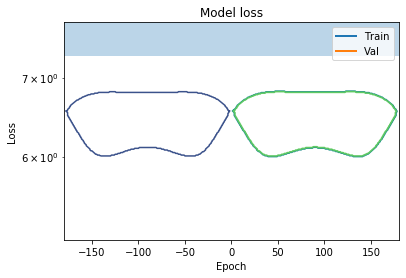

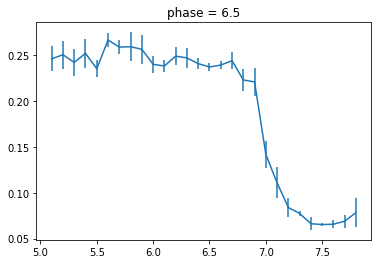

run 2
[(1866, 56, 56, 1)]
(1866, 56, 56, 1)
Epoch 1/30
117/117 [==============================] - 1s 13ms/step - loss: 0.0419 - val_loss: 0.0110
Epoch 2/30
117/117 [==============================] - 1s 11ms/step - loss: 0.0092 - val_loss: 0.0039
Epoch 3/30
117/117 [==============================] - 1s 11ms/step - loss: 0.0055 - val_loss: 0.0029
Epoch 4/30
117/117 [==============================] - 1s 11ms/step - loss: 0.0043 - val_loss: 0.0024
Epoch 5/30
117/117 [==============================] - 1s 11ms/step - loss: 0.0038 - val_loss: 0.0022
Epoch 6/30
117/117 [==============================] - 1s 11ms/step - loss: 0.0034 - val_loss: 0.0019
Epoch 7/30
117/117 [==============================] - 1s 11ms/step - loss: 0.0035 - val_loss: 0.0023
Epoch 8/30
117/117 [==============================] - 1s 11ms/step - loss: 0.0032 - val_loss: 0.0023
Epoch 9/30
117/117 [==============================] - 1s 11ms/step - loss: 0.0032 - val_loss: 0.0020
Epoch 10/30
117/117 [==========================

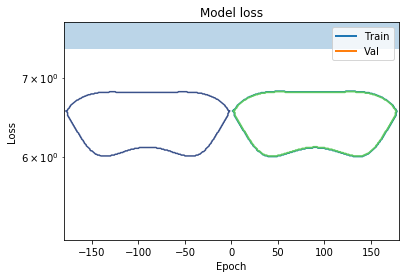

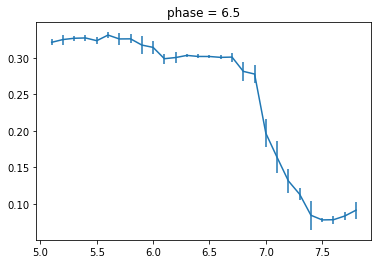

run 3
[(1493, 56, 56, 1)]
(1493, 56, 56, 1)
Epoch 1/30
94/94 [==============================] - 1s 12ms/step - loss: 0.0527 - val_loss: 0.0141
Epoch 2/30
94/94 [==============================] - 1s 11ms/step - loss: 0.0145 - val_loss: 0.0121
Epoch 3/30
94/94 [==============================] - 1s 11ms/step - loss: 0.0108 - val_loss: 0.0057
Epoch 4/30
94/94 [==============================] - 1s 11ms/step - loss: 0.0065 - val_loss: 0.0036
Epoch 5/30
94/94 [==============================] - 1s 11ms/step - loss: 0.0061 - val_loss: 0.0034
Epoch 6/30
94/94 [==============================] - 1s 11ms/step - loss: 0.0059 - val_loss: 0.0032
Epoch 7/30
94/94 [==============================] - 1s 11ms/step - loss: 0.0055 - val_loss: 0.0028
Epoch 8/30
94/94 [==============================] - 1s 11ms/step - loss: 0.0052 - val_loss: 0.0029
Epoch 9/30
94/94 [==============================] - 1s 11ms/step - loss: 0.0051 - val_loss: 0.0030
Epoch 10/30
94/94 [==============================] - 1s 11ms/step

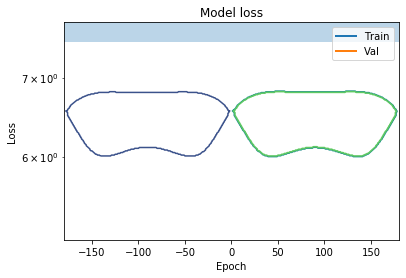

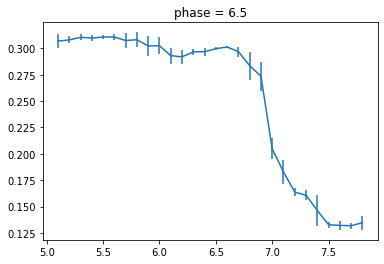

In [136]:
for i,train_freqs in enumerate(train_freqss):
    print(f"run {i}")
    train_phases = [(-180,180)]
    x_train = []
    for phases,freqs in zip(train_phases,train_freqs):
        x_train.append(f["images"][train_mask(*freqs,*phases)][:,:,:,np.newaxis])
    print([_.shape for _ in x_train])
    x_train = np.concatenate(x_train)
    print(x_train.shape)
    fig, ax = plt.subplots()
    ax.contour(x0,y0,np.round(chern_number.T),levels=2)
    for phases,freqs in zip(train_phases,train_freqs):
        plt.fill_between(*[phases],*freqs,alpha=0.3)
    plt.ylim(freq.min(),freq.max())
    plt.xlim(phase.min(),phase.max())

    cnns[i] = full_run(x_train, verbose_val=1,choose_cnn = ConvFully2,load_prev=False,num_batch_epochs = 1, batch_epochs=30, name ="Top_{}".format(train_phases[0][0]), pick_phase=18)

run 2
[(1866, 56, 56, 1)]
(1866, 56, 56, 1)


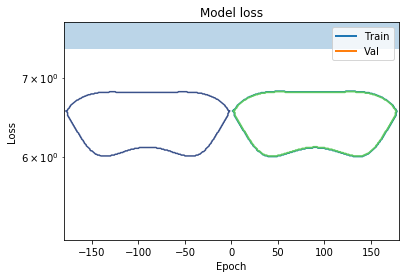

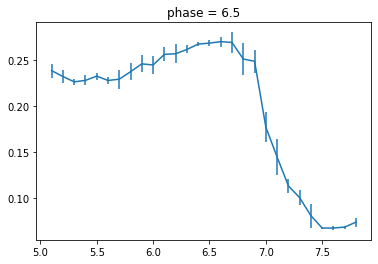

In [152]:
i = 2
train_freqs = train_freqss[i]
print(f"run {i}")
train_phases = [(-180,180)]
x_train = []
for phases,freqs in zip(train_phases,train_freqs):
    x_train.append(f["images"][train_mask(*freqs,*phases)][:,:,:,np.newaxis])
print([_.shape for _ in x_train])
x_train = np.concatenate(x_train)
print(x_train.shape)
fig, ax = plt.subplots()
ax.contour(x0,y0,np.round(chern_number.T),levels=2)
for phases,freqs in zip(train_phases,train_freqs):
    plt.fill_between(*[phases],*freqs,alpha=0.3)
plt.ylim(freq.min(),freq.max())
plt.xlim(phase.min(),phase.max())

cnns[i] = full_run(x_train, verbose_val=0,choose_cnn = ConvFully2,load_prev=False,num_batch_epochs = 1, batch_epochs=30, name ="Top_{}".format(train_phases[0][0]), pick_phase=18)

In [153]:
outs = [create_out(cnn) for cnn in cnns]

In [154]:
np.savez("data/boundary_convergence_outs3",outs=outs)

In [155]:
outs = np.load("data/boundary_convergence_outs3.npz",allow_pickle=True)["outs"]

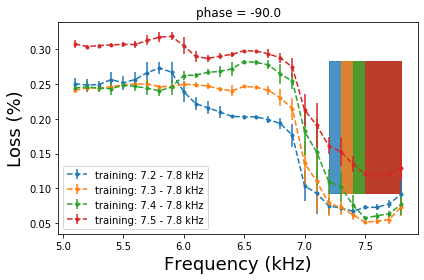

In [156]:
fig, ax = plt.subplots()
color = ["tab:blue","tab:orange", "tab:green", "tab:red", "tab:purple"]
for i in range(len(train_freqss)):
    out, dout = outs[i]
    pick_phase = 18
    plt.errorbar(Y[:,pick_phase],out.T[:,pick_phase],yerr=dout.T[:,pick_phase], fmt = ".--",label=f"training: {starts[i]:.1f} - 7.8 kHz")
plt.legend()
plt.ylabel("Loss (%)", fontsize=18)
plt.xlabel("Frequency (kHz)", fontsize=18)
plt.title(f"phase = {X[:,pick_phase][0]}")
for i in np.arange(4):
    train_freqs = train_freqss[i]
    for phases,freqs in zip(train_phases,train_freqs):
        plt.fill_between(*[freqs],outs[:,0,:,pick_phase].min(),outs[:,0,:,pick_phase].max(),alpha=0.8,color=color[i])
plt.tight_layout()
plt.show()